# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [173]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import random
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix

import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



import warnings
warnings.filterwarnings("ignore")


sns.set(style="ticks", color_codes=True)

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [174]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

In [175]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [176]:
print(azdias.shape)
print(customers.shape)
azdias.describe()

(891221, 366)
(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

### Using the Data Dictionary (DIAS Attributes - Values 2017.xlsx)
The data dictionary gives us a lot of information about the kind of data, what the values actually represent unknown, and gives us a clue about the variance possible.  
We are reading the same file into 2 diff. dataframes:  
   i. The first contains only the first row per attribute  
   ii.The second one contains all the rows, with the attribute value filled from the previous row, so that we can easily look at various values or a given attribute/feature

In [177]:
df_attrs = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
df_values = df_attrs.copy()
df_attrs.drop(columns=df_attrs.columns[0], inplace=True)
df_attrs.dropna(inplace=True)
df_attrs = df_attrs.reset_index()
print(df_attrs.shape)
df_attrs.head()

(314, 6)


,index,Attribute,Description,Value,Meaning,Type
0,0,AGER_TYP,best-ager typology,-1,unknown,Category
1,5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Category
2,11,ALTER_HH,main age within the household,0,unknown / no main age detectable,Numerical
3,33,ANREDE_KZ,gender,"-1, 0",unknown,Category
4,36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),Numerical


In [178]:
df_values.drop(columns=df_values.columns[0], inplace=True)
df_values.Attribute = df_values.Attribute.fillna(method='ffill')
print(df_values.shape)
df_values.head()

(2258, 5)


,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,Category
1,AGER_TYP,NaN,0,no classification possible,NaN
2,AGER_TYP,NaN,1,passive elderly,NaN
3,AGER_TYP,NaN,2,cultural elderly,NaN
4,AGER_TYP,NaN,3,experience-driven elderly,NaN


### Data Exploration

In [179]:
# look at the difference between the data dictionary and the general population dataset
common_columns = (set(list(df_attrs.Attribute)) & set(list(azdias.columns)))
common_columns

{'AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER

In [180]:
# columns in the dataset that is not present in the data dictionary
diff1 = (set(list(azdias.columns))  - set(list(df_attrs.Attribute)))
print('diff: {}, columns: {}'.format(len(diff1), diff1))
print('--------------------------------------------------')
# columns im the data dictionary that are not present in the dataset
diff2 = (set(list(df_attrs.Attribute)) - set(list(azdias.columns)))
print('diff: {}, columns: {}'.format(len(diff2), diff2))

diff: 94, columns: {'CJT_TYP_5', 'D19_KOSMETIK', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'EINGEFUEGT_AM', 'CJT_TYP_2', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL', 'KBA13_HHZ', 'CJT_TYP_4', 'D19_VERSI_DATUM', 'D19_NAHRUNGSERGAENZUNG', 'CJT_TYP_3', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_VERSI_ONLINE_DATUM', 'ALTER_KIND2', 'CJT_TYP_1', 'VK_DHT4A', 'D19_SCHUHE', 'KBA13_ANTG3', 'CAMEO_INTL_2015', 'VK_ZG11', 'D19_BUCH_CD', 'D19_WEIN_FEINKOST', 'D19_BIO_OEKO', 'KBA13_ANTG4', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VOLLSORTIMENT', 'D19_FREIZEIT', 'D19_LOTTO', 'ANZ_KINDER', 'D19_DROGERIEARTIKEL', 'ARBEIT', 'D19_TECHNIK', 'D19_BEKLEIDUNG_GEH', 'ALTER_KIND4', 'D19_TIERARTIKEL', 'VHA', 'VERDICHTUNGSRAUM', 'D19_LETZTER_KAUF_BRANCHE', 'VHN', 'D19_ENERGIE', 'D19_SONSTIGE', 'D19_LEBENSMITTEL', 'DSL_FLAG', 'D19_BILDUNG', 'KONSUMZELLE', 'GEMEINDETYP', 'KBA13_ANTG2', 'RT_KEIN_ANREIZ', 'D19_GARTEN', 'D19_TELKO_REST', 'FIRMENDICHTE', 'D19_BANKEN_LOKAL', 'ALTER_KIND1', 'D19_VERSI_OFFLINE

In [181]:
# many columns in data dictionary have a prefix of RZ.. let's see if we take that into account... what happens
rz_removed = [col.strip('_RZ') for col in list(diff2)]
diff3 = (set(rz_removed) - set(list(azdias.columns)))
print('diff: {}, columns: {}'.format(len(diff3), diff3))
print('-----------')
print(list(rz_removed))

diff: 10, columns: {'D19_RATGEBE', 'HAUSHALTSSTRUKTU', 'KBA13_CCM_1400_2500', 'BIP_FLAG', 'SOHO_FLAG', 'D19_BUCH', 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'D19_KK_KUNDENTYP', 'CAMEO_DEUINTL_2015'}
-----------
['D19_VOLLSORTIMENT', 'KBA13_CCM_1400_2500', 'D19_BEKLEIDUNG_REST', 'D19_LEBENSMITTEL', 'D19_SCHUHE', 'D19_WEIN_FEINKOST', 'D19_VERSICHERUNGEN', 'WACHSTUMSGEBIET_NB', 'D19_BANKEN_DIREKT', 'D19_TELKO_MOBILE', 'BIP_FLAG', 'D19_DIGIT_SERV', 'D19_BANKEN_GROSS', 'D19_SAMMELARTIKEL', 'D19_HAUS_DEKO', 'D19_REISEN', 'D19_KK_KUNDENTYP', 'D19_BANKEN_LOKAL', 'D19_LOTTO', 'D19_RATGEBE', 'D19_BUCH', 'D19_BANKEN_REST', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_KOSMETIK', 'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_TECHNIK', 'D19_BEKLEIDUNG_GEH', 'D19_BILDUNG', 'HAUSHALTSSTRUKTU', 'D19_TIERARTIKEL', 'SOHO_FLAG', 'D19_GARTEN', 'D19_ENERGIE', 'D19_SONSTIGE', 'D19_HANDWERK', 'D19_FREIZEIT', 'GEOSCORE_KLS7', 'D19_VERSAND_REST', 'D19_NAHRUNGSERGAENZUNG', 'CAMEO_DEUINTL_2015']


In [182]:
modified_attr_cols = set(list(df_attrs.Attribute)).union( set(rz_removed))
# print(modified_attr_cols)
# print('----------')
extra_columns = (set(list(azdias.columns)) - set(modified_attr_cols))
print('diff: {}, columns: {}'.format(len(extra_columns), extra_columns))

diff: 62, columns: {'CJT_TYP_5', 'VK_ZG11', 'KOMBIALTER', 'D19_BUCH_CD', 'UMFELD_ALT', 'UMFELD_JUNG', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KBA13_ANTG4', 'SOHO_KZ', 'D19_KONSUMTYP_MAX', 'KONSUMZELLE', 'EINGEFUEGT_AM', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_DISTANZ', 'GEMEINDETYP', 'KBA13_ANTG2', 'RT_SCHNAEPPCHEN', 'RT_KEIN_ANREIZ', 'CJT_TYP_2', 'KBA13_BAUMAX', 'ANZ_KINDER', 'ARBEIT', 'KBA13_ANTG1', 'RT_UEBERGROESSE', 'FIRMENDICHTE', 'KBA13_HHZ', 'ALTER_KIND1', 'CJT_TYP_4', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_DATUM', 'ALTER_KIND4', 'CJT_TYP_3', 'EINGEZOGENAM_HH_JAHR', 'VHA', 'MOBI_RASTER', 'KBA13_KMH_210', 'VERDICHTUNGSRAUM', 'D19_RATGEBER', 'KBA13_CCM_1401_2500', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_SOZIALES', 'AKT_DAT_KL', 'D19_VERSI_ONLINE_DATUM', 'ALTER_KIND2', 'VHN', 'KBA13_GBZ', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_1', 'VK_DHT4A', 'ALTER_KIND3', 'KK_KUNDENTYP', 'LNR', 'KBA13_ANTG3', 'CAMEO_INTL_2015', 'CJT_TYP_6', 'CJT_KATALOG

In [183]:
# We need to get the list of columns where the only diff. between dict and dataset columns in the suffix RZ
azdias_rz_suffixed = azdias.columns + '_RZ'
rzs_to_rename = set(azdias_rz_suffixed).intersection(set(list(df_attrs.Attribute)))
rzs_to_rename

{'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ'}

### Observations
1. There are many extra columns in the data set that are not part of the datta dictionary.   
2. There are a few attributes in the data dictionary that are not part of the dataset.  
3. There are a few attributes that are present in the dataset, where the only diff. between them being, that they are suffixed with "_RZ" in the data dictionary.  
Let us first remove the "_RZ" suffix in the Data Dictionary where they are present in the dataset without that suffix

In [184]:
for col in rzs_to_rename:
    df_attrs.Attribute.replace(col, col.strip('_RZ'), inplace=True)
    df_values.Attribute.replace(col, col.strip('_RZ'), inplace=True)

### Unknown and missing values
There are many values that actually represent a unknown/missing value.  
Let's collect a list of these values for each of the attributes in the Data Dictionary

In [185]:
def get_missing_values(df):
    missing_dict = dict()
    missing_indicators = [
        'unknown',
        'no transaction known',
        'no transactions known'
    ]
    for i in df.index:
        if df['Meaning'][i] in missing_indicators:
            missing_dict[df['Attribute'][i]] = df['Value'][i]
    
    missing_dict['CAMEO_DEUINTL_2015'] = -1
    
    return missing_dict

In [186]:
missing_values_dict = get_missing_values(df_values)
missing_values_dict

{'AGER_TYP': -1,
 'ALTERSKATEGORIE_GROB': '-1, 0',
 'ANREDE_KZ': '-1, 0',
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_BANKEN_ANZ_12': 0,
 'D19_BANKEN_ANZ_24': 0,
 'D19_BANKEN_DATUM': 10,
 'D19_BANKEN_DIREKT': 0,
 'D19_BANKEN_GROSS': 0,
 'D19_BANKEN_LOKAL': 0,
 'D19_BANKEN_OFFLINE_DATUM': 10,
 'D19_BANKEN_ONLINE_DATUM': 10,
 'D19_BANKEN_REST': 0,
 'D19_BEKLEIDUNG_GEH': 0,
 'D19_BEKLEIDUNG_REST': 0,
 'D19_BILDUNG': 0,
 'D19_BIO_OEKO': 0,
 'D19_BUCH_RZ': 0,
 'D19_DIGIT_SERV': 0,
 'D19_DROGERIEARTIKEL': 0,
 'D19_ENERGIE': 0,
 'D19_FREIZEIT': 0,
 'D19_GARTEN': 0,
 'D19_GESAMT_ANZ_12': 0,
 'D19_GESAMT_ANZ_24': 0,
 'D19_GESAMT_DATUM': 10,
 'D19_GESAMT_OFFLINE_DATUM': 10,
 'D19_GESAMT_ONLINE_DATUM': 10,
 'D19_HANDWERK': 0,
 'D19_HAUS_DEKO': 0,
 'D19_KINDERARTIKEL': 0,
 'D19_KK_KUNDENTYP': -1,
 'D19_KOSMETIK': 0,
 'D19_LEBENSMITTEL': 0,
 'D19_LOTTO': 0,
 'D19_NAHRUNGSERGAENZUNG': 0,
 'D19_RATGEBE': 0,
 'D19_REISEN': 0,
 'D19_SA

### Replacing unknown values with NaN
All the values that actually represent an unknown/missing value, should be replaced with NaN so that they can be properly participate in the ML Model building propcess

In [187]:
def mark_missing_values_as_null(df, missing_values_dict):
    for col in df.columns:
#       if the column exists in the data dictionary
        if col in missing_values_dict.keys():
            unknown_values =  list(map(int, str(missing_values_dict[col]).strip().split(',')))
            for unknown_value in unknown_values:
                df[col] = df[col].replace(unknown_value, np.NaN)
            print(unknown_values)
    return df

Let's create a copy of the original dataset, so that we can test/check the changes that have happened and make sure that they are proper.

In [188]:
azdias_cp = azdias.copy()

In [189]:
azdias_cp = mark_missing_values_as_null(azdias_cp, missing_values_dict)

[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[0]
[0]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]

#### Other values that are not explicitly mentioned in the Data Dictionary. but repesent unknown
There are a few columns that contain 'X' and 'XX' values, which seem to represent unknowns and hence let's replace them as NaN's as well.

In [190]:
# There are a few values like X and XX specific to a few columns that also represent missing values.. let's add that to the dictionary
cols = 'CAMEO_INTL_2015,CAMEO_DEUG_2015,CAMEO_DEU_2015'.split(',')
for col in cols:
    azdias_cp[col].replace('X', np.NaN, inplace=True)
    azdias_cp[col].replace('XX', np.NaN, inplace=True)

### Analyzing  null distribution per feature

In [191]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Pe\rcentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

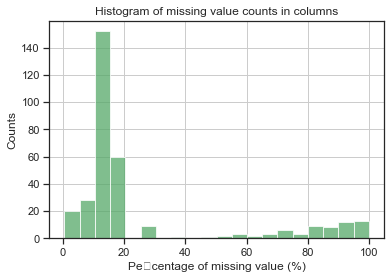

,nulls,pct
ALTER_KIND4,890016,99.86
TITEL_KZ,889061,99.76
ALTER_KIND3,885051,99.31
D19_TELKO_ONLINE_DATUM,883018,99.08
D19_BANKEN_LOKAL,874745,98.15
D19_BANKEN_OFFLINE_DATUM,871535,97.79
ALTER_KIND2,861722,96.69
D19_TELKO_ANZ_12,857990,96.27
D19_DIGIT_SERV,857661,96.23
D19_BIO_OEKO,854074,95.83


In [192]:
# let's look at the distribution of nulls
azdias_nulls = get_null_counts(azdias_cp)
plot_hist_missing_col(azdias_nulls)
azdias_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False, inplace=True)
azdias_nulls[azdias_nulls.pct>20]

### Analysis of Null distribution
It is clear from the above that most of the columns/features have less than 30%% of their values as null.
There is a sharp jumo from less than 30% to 40% of null values per attribute.  
40%% of null for a feature makes it risky to be filled with a mean/median/mode value.. as it might bias the dataset itself.  
Hence let's drop all the coliumns/features that have more than 30%% or their values as NaNs

In [193]:
cols_to_drop = azdias_nulls[azdias_nulls.pct>30].index
cols_to_drop

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2',
       'D19_TELKO_ANZ_12', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL',
       'D19_WEIN_FEINKOST', 'D19_BANKEN_ANZ_12', 'D19_ENERGIE',
       'D19_TELKO_ANZ_24', 'D19_BANKEN_REST', 'D19_VERSI_ANZ_12',
       'D19_TELKO_OFFLINE_DATUM', 'D19_BILDUNG', 'ALTER_KIND1',
       'D19_BEKLEIDUNG_GEH', 'D19_SAMMELARTIKEL', 'D19_BANKEN_ANZ_24',
       'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_VERSI_ANZ_24', 'D19_SCHUHE',
       'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL',
       'D19_KINDERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK', 'D19_REISEN',
       'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_ONLINE_DATUM',
       'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_BANKEN_DATUM', 'AGER_TYP', 'D19_TELKO_DATUM', 'D19_VERSICHERUNGEN',
       'E

### Ad additional columns/features to drop
After a careful perusal of the Data Dictionary, it seems like a few other features can be dropped because of the following reasons:  
1. They contain information already part of another feature or is very similar to another feature
2. 'LNR' is reallly a row identofier and hence isn't needed
3. 'CAMEO_DEU_2015' contains too many categories

In [194]:
additional_cols_to_drop = "'LNR' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_TITEL' 'CAMEO_DEU_2015'" + \
" 'GEBAEUDETYP' 'GEBURTSJAHR' 'KBA05_MODTEMP' 'LP_FAMILIE_FEIN'" + \
" 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_STATUS_FEIN' 'PLZ8_ANTG1'" + \
" 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'VERDICHTUNGSRAUM' 'VK_DHT4A'" + \
" 'VK_DISTANZ' 'VK_ZG11' 'ALTERSKATEGORIE_FEIN' 'D19_TELKO_ONLINE_QUOTE_12'" + \
" 'D19_LETZTER_KAUF_BRANCHE' 'D19_VERSI_ONLINE_QUOTE_12'"
additional_cols_to_drop = additional_cols_to_drop.replace("'","")
additional_cols_to_drop = additional_cols_to_drop.split(' ')
additional_cols_to_drop

['LNR',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_TITEL',
 'CAMEO_DEU_2015',
 'GEBAEUDETYP',
 'GEBURTSJAHR',
 'KBA05_MODTEMP',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'VERDICHTUNGSRAUM',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11',
 'ALTERSKATEGORIE_FEIN',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_VERSI_ONLINE_QUOTE_12']

In [195]:
total_cols_to_drop = set(additional_cols_to_drop).union( set(cols_to_drop))
total_cols_to_drop

{'AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_TITEL',
 'CAMEO_DEU_2015',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_MOBILE',
 

In [196]:
set(total_cols_to_drop).difference( set(list(azdias_cp.columns)))

set()

In [197]:
azdias_cp.drop(columns=list(total_cols_to_drop), inplace=True)

In [198]:
azdias_cp.shape

(891221, 279)

In [199]:
# let's get a sense of all the columns still in the dataset but not in the data dictionary
dict_columns = df_attrs.Attribute.values
extra_columns = set(azdias_cp.columns).difference(set(dict_columns))

Let's get a sense of the extra columns in the dataset, which are not mentioned as part of the Data Dictionary

In [200]:
azdias_cp[extra_columns].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CJT_TYP_5                   886367 non-null  float64
 1   KOMBIALTER                  891221 non-null  int64  
 2   D19_BUCH_CD                 891221 non-null  int64  
 3   UMFELD_ALT                  793435 non-null  float64
 4   UMFELD_JUNG                 793435 non-null  float64
 5   DSL_FLAG                    798073 non-null  float64
 6   UNGLEICHENN_FLAG            817722 non-null  float64
 7   KBA13_ANTG4                 785421 non-null  float64
 8   SOHO_KZ                     817722 non-null  float64
 9   D19_KONSUMTYP_MAX           891221 non-null  int64  
 10  EINGEFUEGT_AM               798073 non-null  object 
 11  ANZ_STATISTISCHE_HAUSHALTE  798073 non-null  float64
 12  KONSUMZELLE                 798066 non-null  float64
 13  GEMEINDETYP   

Remove CAMEO_INTL_2015 from the extra column list, since it is defined in the Data Dictionary with a slightly diff. name

In [201]:
# The folllowing feature name on the left resembles the attribute in Data Dictionary on the right
# Let's see if both exists in the Data set, and if they do, then we should drop that one extra column
extra_column_map =[]
extra_column_map.append(('D19_BUCH_CD','D19_BUCH_RZ'))
extra_column_map.append(('KBA13_ANTG4','KBA05_ANTG4'))
extra_column_map.append(('SOHO_KZ','SOHO_FLAG'))
extra_column_map.append(('D19_KONSUMTYP_MAX','D19_KONSUMTYP'))
extra_column_map.append(('KBA13_ANTG2','KBA05_ANTG2'))
extra_column_map.append(('KBA13_BAUMAX','KBA05_BAUMAX'))
extra_column_map.append(('KBA13_ANTG1','KBA05_ANTG1'))
extra_column_map.append(('KBA13_HHZ','PLZ8_HHZ'))
extra_column_map.append(('D19_RATGEBER','D19_RATGEBER_RZ'))
extra_column_map.append(('KBA13_GBZ','KBA05_GBZ'))
extra_column_map.append(('KBA13_ANTG3','KBA05_ANTG3'))
extra_column_map.append(('CAMEO_INTL_2015','CAMEO_DEUINTL_2015'))
# 
extra_duplicate_columns = []

for extra_col_map in extra_column_map:
    if extra_col_map[1] not in azdias_cp.columns:
#         print(extra_col_map[1])
        extra_duplicate_columns.append(extra_col_map[0])

extra_duplicate_columns

['D19_BUCH_CD', 'SOHO_KZ', 'KBA13_BAUMAX', 'D19_RATGEBER', 'CAMEO_INTL_2015']

In [202]:
extra_mapped_cols = (col1 for col1, col2 in extra_column_map)
final_extra_cols = list(set(extra_columns).difference(set(extra_mapped_cols)))
final_extra_cols

['CJT_TYP_5',
 'KOMBIALTER',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'DSL_FLAG',
 'UNGLEICHENN_FLAG',
 'EINGEFUEGT_AM',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'KONSUMZELLE',
 'GEMEINDETYP',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'CJT_TYP_2',
 'ARBEIT',
 'RT_UEBERGROESSE',
 'FIRMENDICHTE',
 'CJT_TYP_4',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_DATUM',
 'CJT_TYP_3',
 'EINGEZOGENAM_HH_JAHR',
 'VHA',
 'MOBI_RASTER',
 'KBA13_KMH_210',
 'KBA13_CCM_1401_2500',
 'D19_SOZIALES',
 'D19_VERSI_ONLINE_DATUM',
 'AKT_DAT_KL',
 'VHN',
 'CJT_TYP_1',
 'CJT_TYP_6',
 'CJT_KATALOGNUTZER',
 'STRUKTURTYP',
 'HH_DELTA_FLAG']

In [205]:
for col in final_extra_cols:
    if col not in ['EINGEFUEGT_AM','ANZ_STATISTISCHE_HAUSHALTE','EINGEZOGENAM_HH_JAHR']:
        print('{} has {} unique columns'.format(col, azdias_cp[col].unique()))

CJT_TYP_5 has [ 5.  1.  2.  3.  4. nan] unique columns
KOMBIALTER has [9 1 2 4 3] unique columns
UMFELD_ALT has [nan  3.  2.  4.  5.  1.] unique columns
UMFELD_JUNG has [nan  3.  5.  4.  2.  1.] unique columns
DSL_FLAG has [nan  1.  0.] unique columns
UNGLEICHENN_FLAG has [nan  1.  0.] unique columns
KONSUMZELLE has [nan  1.  0.] unique columns
GEMEINDETYP has [nan 22. 40. 21. 12. 30. 11. 50.] unique columns
RT_KEIN_ANREIZ has [ 1.  5.  3.  4.  2. nan] unique columns
RT_SCHNAEPPCHEN has [ 4.  3.  2.  5.  1. nan] unique columns
CJT_TYP_2 has [ 1.  5.  4.  2.  3. nan] unique columns
ARBEIT has [nan  3.  2.  4.  1.  5.  9.] unique columns
RT_UEBERGROESSE has [ 1.  5.  3.  4. nan  2.  0.] unique columns
FIRMENDICHTE has [nan  2.  4.  5.  3.  1.] unique columns
CJT_TYP_4 has [ 5.  3.  4.  1.  2. nan] unique columns
D19_VERSI_OFFLINE_DATUM has [10  7  9  6  4  8  5  2  3  1] unique columns
D19_VERSI_DATUM has [10  2  8  9  6  7  5  1  4  3] unique columns
CJT_TYP_3 has [ 5.  2.  1.  4.  3. n

It is clear from the above that 'DSL_FLAG,UNGLEICHENN_FLAG,KONSUMZELLE,HH_DELTA_FLAG' are binary types.

In [248]:
# Since we do not know what exactly are the rest of the columns.. let's consider them category types
extra_category_types = set(final_extra_cols) \
                        .difference(set('DSL_FLAG,UNGLEICHENN_FLAG,KONSUMZELLE,HH_DELTA_FLAG'.split(',')))
extra_category_types = extra_category_types.difference(set(['EINGEFUEGT_AM','ANZ_STATISTISCHE_HAUSHALTE', \
                                                       'EINGEZOGENAM_HH_JAHR']))
','.join(extra_category_types)

'CJT_TYP_5,CJT_TYP_4,D19_VERSI_OFFLINE_DATUM,KOMBIALTER,D19_VERSI_DATUM,CJT_TYP_3,UMFELD_ALT,VHA,MOBI_RASTER,UMFELD_JUNG,KBA13_KMH_210,KBA13_CCM_1401_2500,D19_SOZIALES,D19_VERSI_ONLINE_DATUM,AKT_DAT_KL,VHN,GEMEINDETYP,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,CJT_TYP_1,CJT_TYP_2,ARBEIT,CJT_TYP_6,RT_UEBERGROESSE,CJT_KATALOGNUTZER,STRUKTURTYP,FIRMENDICHTE'

In [209]:
# now let's look at the columns that have a lot of unique values to understand them
azdias_cp[['EINGEFUEGT_AM','ANZ_STATISTISCHE_HAUSHALTE','EINGEZOGENAM_HH_JAHR']].head()

,EINGEFUEGT_AM,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR
0,NaN,NaN,NaN
1,1992-02-10 00:00:00,12.0,2004.0
2,1992-02-12 00:00:00,7.0,2000.0
3,1997-04-21 00:00:00,2.0,1998.0
4,1992-02-12 00:00:00,3.0,2004.0


In [210]:
# it is clear from the above that EINGEFUEGT_AM is date type... and it looks like only the year portion of it will suffice

In [92]:
# Since we have no idea what these features are and if they are categorical or not...
# let's drop all the extra columns that we cannot map to some column in the Data Dictionary
','.join(list(final_extra_cols))

'CJT_TYP_5,KOMBIALTER,UMFELD_ALT,UMFELD_JUNG,DSL_FLAG,UNGLEICHENN_FLAG,EINGEFUEGT_AM,ANZ_STATISTISCHE_HAUSHALTE,KONSUMZELLE,GEMEINDETYP,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,CJT_TYP_2,ARBEIT,RT_UEBERGROESSE,FIRMENDICHTE,CJT_TYP_4,D19_VERSI_OFFLINE_DATUM,D19_VERSI_DATUM,CJT_TYP_3,EINGEZOGENAM_HH_JAHR,VHA,MOBI_RASTER,KBA13_KMH_210,KBA13_CCM_1401_2500,D19_SOZIALES,D19_VERSI_ONLINE_DATUM,AKT_DAT_KL,VHN,CJT_TYP_1,CJT_TYP_6,CJT_KATALOGNUTZER,STRUKTURTYP,HH_DELTA_FLAG'

In [214]:
# azdias_cp.drop(columns=list(final_extra_cols), inplace=True)

The EINGEFUEGT_AM columns contains Datetime info.. and it seems that only the year part is important.  
Hence let's extract the year part of this feature and keep it.

In [215]:
azdias_cp[['EINGEFUEGT_AM']].head()

,EINGEFUEGT_AM
0,NaN
1,1992-02-10 00:00:00
2,1992-02-12 00:00:00
3,1997-04-21 00:00:00
4,1992-02-12 00:00:00


In [216]:
# EINGEFUEGT_AM should be converted into ints equivalent year. Not sure what it means
azdias_cp["EINGEFUEGT_AM"] = pd.to_datetime(azdias_cp["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
azdias_cp["EINGEFUEGT_AM"] = azdias_cp["EINGEFUEGT_AM"].dt.year

#### Missing info per row
Now let's look at distribution of missing information per row.

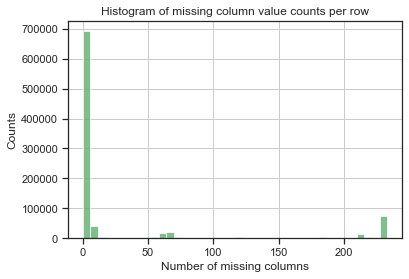

In [217]:
# now let's look at the missing info per row and it's distribution
null_row_counts = azdias_cp.isnull().sum(axis=1)
null_row_counts.values

plt.hist(null_row_counts.values, bins=40, facecolor='g', alpha=0.75)

plt.xlabel('Number of missing columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of missing column value counts per row', fontsize=12)
plt.grid(True)
plt.show()

### Observations on missing info per row
From the above, it is clear that most of the rows contain less than 30 features having nulls.  
Replacing too many nulls per row, once again is likely to create a biased data and lead to unreliable analysis.  
Hence let's drop all the rows that have more than 40 of their features having NaNs

In [218]:
# most of the rows contain less than 25-30 columns with missing values
# let's drop these rows, as otherwise we are likely to create biased data
print(azdias_cp.shape)
azdias_cp = azdias_cp.dropna(thresh=len(azdias_cp.columns)-30)
azdias_cp.reset_index(drop=True, inplace=True)
azdias_cp.shape

(891221, 279)


(737288, 279)

### Feature Engineering
There are a few columns that need transformations becuase of the following reasons:  
  i.  There are a few columns that seem to contain mixed information and hence new features are being engineered from them.  
  ii. 'OST_WEST_KZ' needs to be binary encoded, since it contains only 2 character values.

In [219]:
def get_missing_dict(df):
    missing_dict = dict()
    missing_indicators = ['unknown','no transaction known','no transactions known']
    for i in df.index:
        if df['Meaning'][i] in missing_indicators:
            missing_dict[df['Attribute'][i]] = df['Value'][i]
    
    missing_dict['CAMEO_DEUINTL_2015'] = -1
    return missing_dict

def engineer_features(df):
#   refer to the values of CAMEO_DEUINTL_2015 in the excel sheet.
    df['HOUSEHOLD'] = df['CAMEO_INTL_2015'].str[:1].astype(float)
    df['FAMILY_TYPE'] = df['CAMEO_INTL_2015'].str[1:2].astype(float)

#   create feature to indicate whether the movement was meainstream or not
    df['MAINSTREAM'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MAINSTREAM'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                           [np.nan,np.nan,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0], inplace=True) 

#   create a feature to indicate the decade
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace([-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                                    [np.nan,np.nan,4,4,5,5,6,6,6,7,7,8,8,8,8,9,9], inplace=True) 

#   extract if the neigbourhood is rural or not
    df['RURAL_NEIGHBORHOOD'] = df['WOHNLAGE']
    df['RURAL_NEIGHBORHOOD'].replace([-1,0,1,2,3,4,5,7,8], [np.nan,np.nan,0,0,0,0,0,1,1], inplace=True)

#   Extract if the builsing is a business complex
    df['PLZ8_BAUMAX_BUSINESS'] = df['PLZ8_BAUMAX']
    df['PLZ8_BAUMAX_BUSINESS'].replace([1,2,3,4,5], [0,0,0,0,1], inplace=True) 

#   in case of business building, the number of family homes is taken to be 0
    df['PLZ8_BAUMAX_FAMILY'] = df['PLZ8_BAUMAX']
    df['PLZ8_BAUMAX_FAMILY'].replace([5], [0], inplace=True) 

    df.drop(columns=['PLZ8_BAUMAX', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'], inplace=True)

    return df


def mark_missing_values_as_null(df, missing_values_dict):
    for col in df.columns:
        if col in missing_values_dict.keys():
            unknown_values =  list(map(int, str(missing_values_dict[col]).strip().split(',')))
            for unknown_value in unknown_values:
                df[col] = df[col].replace(unknown_value, np.NaN)
            print(unknown_values)
    return df

In [220]:
print(azdias_cp.shape)
azdias_cp =  engineer_features(azdias_cp)
azdias_cp.shape

(737288, 279)


(737288, 282)

In [221]:
azdias_cp['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)
azdias_cp.OST_WEST_KZ.unique()

array([1, 0])

### Feature types
There are different types of features, that might need to be treated differently when imputing missing values as well applying different scalig methodologies to them
1. 

In [222]:
# The following are binary categories
binary_columns = ['RURAL_NEIGHBORHOOD', 'GREEN_AVANTGARDE', 'VERS_TYP', 'PLZ8_BAUMAX_BUSINESS', 
                  'KBA05_SEG6', 'ANREDE_KZ', 'MAINSTREAM', 'OST_WEST_KZ', 'SOHO_KZ',
                  'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KONSUMZELLE', 'HH_DELTA_FLAG']
for col in binary_columns:
    print(azdias_cp[col].unique())

[ 0.  1. nan]
[0 1]
[ 2.  1. nan]
[ 0.  1. nan]
[1. 0.]
[2 1]
[ 1.  0. nan]
[1 0]
[1. 0.]
[1. 0.]
[1. 0.]
[ 1.  0. nan]
[ 0. nan  1.]


In [249]:
# the following are categorical columns

# ['AKT_DAT_KL', 'ARBEIT', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'D19_KONSUMTYP', 
#                        'FINANZTYP', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'GFK_URLAUBERTYP', 
#                        'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA13_BAUMAX', 
#                        'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 
#                        'SHOPPER_TYP', 'STRUKTURTYP', 'UMFELD_ALT', 'VHA', 'ZABEOTYP']



# 'CJT_TYP_5,CJT_TYP_4,D19_VERSI_OFFLINE_DATUM,KOMBIALTER,D19_VERSI_DATUM,CJT_TYP_3,
# UMFELD_ALT,VHA,MOBI_RASTER,UMFELD_JUNG,KBA13_KMH_210,KBA13_CCM_1401_2500,
# D19_SOZIALES,D19_VERSI_ONLINE_DATUM,AKT_DAT_KL,VHN,GEMEINDETYP,RT_KEIN_ANREIZ,
# RT_SCHNAEPPCHEN,CJT_TYP_1,CJT_TYP_2,ARBEIT,CJT_TYP_6,RT_UEBERGROESSE,
# CJT_KATALOGNUTZER,STRUKTURTYP,FIRMENDICHTE'

categorical_columns = ['SHOPPER_TYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                       'KBA05_MAXHERST', 'ZABEOTYP', 'FINANZTYP', 'KBA05_HERSTTEMP', 
                       'KBA13_BAUMAX', 'GFK_URLAUBERTYP', 'D19_KONSUMTYP', 'CJT_TYP_5',
                      'CJT_TYP_4', 'D19_VERSI_OFFLINE_DATUM', 'KOMBIALTER',
                      'D19_VERSI_DATUM', 'CJT_TYP_3', 'UMFELD_ALT', 'VHA',
                      'MOBI_RASTER', 'UMFELD_JUNG', 'KBA13_KMH_210', 'KBA13_CCM_1401_2500',
                      'D19_SOZIALES', 'D19_VERSI_ONLINE_DATUM',
                      'AKT_DAT_KL', 'VHN', 'GEMEINDETYP', 'RT_KEIN_ANREIZ',
                      'RT_SCHNAEPPCHEN', 'CJT_TYP_1', 'CJT_TYP_2', 'ARBEIT',
                      'CJT_TYP_6', 'RT_UEBERGROESSE', 'CJT_KATALOGNUTZER', 'STRUKTURTYP',
                      'FIRMENDICHTE']
azdias_cp[categorical_columns].head()

,SHOPPER_TYP,CJT_GESAMTTYP,GEBAEUDETYP_RASTER,HEALTH_TYP,KBA05_MAXHERST,ZABEOTYP,FINANZTYP,KBA05_HERSTTEMP,KBA13_BAUMAX,GFK_URLAUBERTYP,D19_KONSUMTYP,CJT_TYP_5,CJT_TYP_4,D19_VERSI_OFFLINE_DATUM,KOMBIALTER,D19_VERSI_DATUM,CJT_TYP_3,UMFELD_ALT,VHA,MOBI_RASTER,UMFELD_JUNG,KBA13_KMH_210,KBA13_CCM_1401_2500,D19_SOZIALES,D19_VERSI_ONLINE_DATUM,AKT_DAT_KL,VHN,GEMEINDETYP,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,CJT_TYP_1,CJT_TYP_2,ARBEIT,CJT_TYP_6,RT_UEBERGROESSE,CJT_KATALOGNUTZER,STRUKTURTYP,FIRMENDICHTE
0,3.0,5.0,3.0,3.0,2.0,5,1,4.0,2.0,10.0,NaN,1.0,3.0,10,1,10,2.0,3.0,0.0,1.0,3.0,4.0,3.0,NaN,10,9.0,4.0,22.0,5.0,3.0,5.0,5.0,3.0,1.0,5.0,1.0,2.0,2.0
1,2.0,3.0,4.0,3.0,5.0,5,1,4.0,1.0,10.0,9.0,2.0,3.0,10,2,10,1.0,2.0,0.0,2.0,5.0,4.0,3.0,0.0,10,9.0,2.0,22.0,5.0,4.0,4.0,4.0,3.0,2.0,5.0,2.0,3.0,4.0
2,1.0,2.0,4.0,2.0,3.0,3,6,3.0,1.0,1.0,9.0,5.0,4.0,10,4,10,4.0,4.0,1.0,4.0,5.0,2.0,2.0,0.0,10,1.0,0.0,40.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,4.0
3,2.0,5.0,5.0,3.0,3.0,4,5,3.0,2.0,5.0,1.0,3.0,4.0,7,3,2,3.0,4.0,0.0,1.0,3.0,3.0,1.0,0.0,10,1.0,2.0,21.0,3.0,5.0,3.0,3.0,4.0,3.0,5.0,3.0,3.0,5.0
4,0.0,2.0,4.0,3.0,2.0,4,2,4.0,1.0,1.0,4.0,3.0,5.0,10,4,8,5.0,3.0,0.0,3.0,3.0,4.0,4.0,4.0,10,1.0,2.0,40.0,4.0,4.0,2.0,1.0,2.0,3.0,3.0,5.0,2.0,4.0


In [250]:
# Let's look at the skew of the data distribution and identify columns that need logarithmic scaling rather than a standard scaling
continuous_columns = []
cols = set(azdias_cp.columns).difference( (set(categorical_columns).union(set(binary_columns))))
for col in cols:
    skew = azdias_cp[col].skew()
    if abs(skew) >= 1:
        continuous_columns.append(col)
continuous_columns

['EINGEFUEGT_AM',
 'WOHNDAUER_2008',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_PERSONEN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'ANZ_HAUSHALTE_AKTIV',
 'NATIONALITAET_KZ',
 'MIN_GEBAEUDEJAHR',
 'PLZ8_BAUMAX_FAMILY',
 'KBA05_ANTG4',
 'D19_RATGEBER',
 'KBA05_ANTG3',
 'KBA13_KMH_251',
 'KBA13_KMH_110',
 'KBA13_ANZAHL_PKW',
 'KBA13_KW_30']

In [251]:
other_numerical_attributes = azdias_cp.columns[~azdias_cp.columns.isin(binary_columns + continuous_columns + categorical_columns)]
other_numerical_attributes

Index(['ALTER_HH', 'BALLRAUM', 'CAMEO_DEUG_2015', 'D19_BUCH_CD',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP_MAX',
       'D19_VERSAND_ONLINE_QUOTE_12', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE',
       'FINANZ_ANLEGER',
       ...
       'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT',
       'W_KEIT_KIND_HH', 'ALTERSKATEGORIE_GROB', 'HOUSEHOLD', 'FAMILY_TYPE',
       'DECADE'],
      dtype='object', length=215)

### Resuable function to clean data
Let's encapsulate the cleaning llofic into a reusable function so that it can be used to clean the diff. datasets

In [252]:
def clean_data(df, delete_null_rows=True):
    missing_values_dict = get_missing_dict(df_values)
    df = mark_missing_values_as_null(df, missing_values_dict)

    cols = 'CAMEO_INTL_2015,CAMEO_DEUG_2015,CAMEO_DEU_2015'.split(',')
    for col in cols:
        df[col].replace('X', np.NaN, inplace=True)
        df[col].replace('XX', np.NaN, inplace=True)

    null_cols_to_drop = ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM',
                       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2',
                       'D19_TELKO_ANZ_12', 'D19_DIGIT_SERV', 'D19_BIO_OEKO',
                       'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN',
                       'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_BANKEN_ANZ_12',
                       'D19_ENERGIE', 'D19_TELKO_ANZ_24', 'D19_BANKEN_REST',
                       'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'D19_BILDUNG',
                       'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_SAMMELARTIKEL',
                       'D19_BANKEN_ANZ_24', 'D19_FREIZEIT', 'D19_BANKEN_GROSS',
                       'D19_VERSI_ANZ_24', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST',
                       'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_LOTTO',
                       'D19_KOSMETIK', 'D19_REISEN', 'D19_VERSAND_REST',
                       'D19_BANKEN_DIREKT', 'D19_BANKEN_ONLINE_DATUM', 'D19_TELKO_MOBILE',
                       'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_BANKEN_DATUM',
                       'AGER_TYP', 'D19_TELKO_DATUM', 'D19_VERSICHERUNGEN', 'EXTSEL992',
                       'D19_VERSAND_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'D19_TECHNIK',
                       'D19_VOLLSORTIMENT', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP',
                       'D19_VERSAND_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_SONSTIGE',
                       'D19_GESAMT_ANZ_24', 'D19_VERSAND_ONLINE_DATUM', 'KBA05_BAUMAX',
                       'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_GESAMT_DATUM']
    
    
    additional_columns_to_drop = "'LNR' 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_TITEL' 'CAMEO_DEU_2015'" + \
                                " 'GEBAEUDETYP' 'GEBURTSJAHR' 'KBA05_MODTEMP' 'LP_FAMILIE_FEIN'" + \
                                " 'LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_STATUS_FEIN' 'PLZ8_ANTG1'" + \
                                " 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'VERDICHTUNGSRAUM' 'VK_DHT4A'" + \
                                " 'VK_DISTANZ' 'VK_ZG11' 'ALTERSKATEGORIE_FEIN' 'D19_TELKO_ONLINE_QUOTE_12'" + \
                                " 'D19_LETZTER_KAUF_BRANCHE' 'D19_VERSI_ONLINE_QUOTE_12'"
    additional_columns_to_drop = additional_columns_to_drop.replace("'","")
    additional_columns_to_drop = additional_columns_to_drop.split(' ')
    

    df = df.drop(columns = null_cols_to_drop)
    df.drop(columns=additional_columns_to_drop, inplace=True)
    
    # not sure what the column EINGEFUEGT_AM means, but it contains datetime value that should be meaningfully converted
    # either into numeric value... here the year of the date seems reasonable
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"], format='%Y/%m/%d %H:%M')
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].dt.year
    
    if delete_null_rows:
        df = df.dropna(thresh=len(df.columns)-30)
        df.reset_index(drop=True, inplace=True)

#       in case this is a customers dataset, then also drop the additional columns
    try:
        df = df.drop(columns=['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'])
    except:
        pass

    
    df =  engineer_features(df)
    df['OST_WEST_KZ'].replace(['O','W'], [0, 1], inplace=True)

    df = df.astype(float) # just to be sure
    return df

#### Featrure Transformation pipelines
Let's create different transformation pipelines for different type of columns
The following pipelines are needed:
1. For categorical values, we need to create new features per unique value.
2. For binary values, we want to simply impute the missing values with their most frequent value
3. For highly skewed features, we want to first apply log scaling, then impute missing values with their medians, and then apply standard scaling so as to bring it in sync with every other feature
4. For other numeric features, we want to impoute missing values with their medians and then applly standard scaling.

In [253]:
# create different transsformation pipelines for different columns, 
# depending on how they need to be scaled and what imputatipn is be applied
log_transform = ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline([log_transform, log_impute, log_scale])

In [254]:
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [255]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline([num_impute, num_scale])

In [256]:
for col in categorical_columns:
    print('{} has {} missing values'.format(col, azdias_cp[col].isnull().sum()))
    print(azdias_cp[col].unique())

SHOPPER_TYP has 34054 missing values
[ 3.  2.  1.  0. nan]
CJT_GESAMTTYP has 4382 missing values
[ 5.  3.  2.  4.  1.  6. nan]
GEBAEUDETYP_RASTER has 5 missing values
[ 3.  4.  5.  2.  1. nan]
HEALTH_TYP has 34054 missing values
[ 3.  2.  1. nan]
KBA05_MAXHERST has 0 missing values
[2. 5. 3. 1. 4.]
ZABEOTYP has 0 missing values
[5 3 4 1 6 2]
FINANZTYP has 0 missing values
[1 6 5 2 4 3]
KBA05_HERSTTEMP has 3743 missing values
[ 4.  3.  1.  2.  5. nan]
KBA13_BAUMAX has 0 missing values
[2. 1. 4. 5. 3.]
GFK_URLAUBERTYP has 4382 missing values
[10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
D19_KONSUMTYP has 164072 missing values
[nan  9.  1.  4.  3.  6.  5.  2.]
CJT_TYP_5 has 4382 missing values
[ 1.  2.  5.  3.  4. nan]
CJT_TYP_4 has 4382 missing values
[ 3.  4.  5.  1.  2. nan]
D19_VERSI_OFFLINE_DATUM has 0 missing values
[10  7  9  6  4  8  5  2  3  1]
KOMBIALTER has 0 missing values
[1 2 4 3 9]
D19_VERSI_DATUM has 0 missing values
[10  2  8  9  7  5  6  1  4  3]
CJT_TYP_3 has 43

In [257]:
# the following is temp. Replace this with better code
class DummiesTransformer(BaseEstimator, TransformerMixin):
    '''
    A Dataframe transformer that provide dummy variable encoding
    
    '''    
    def transform(self, X, **transformparams):
        '''
        Returns a dummy variable encoded version of a DataFrame
        
        Inputs:
            X :pandas DataFrame
        
        Returns:
            X_transformed: pandas DataFrame with new encoding    
        '''
        # check that we have a DataFrame with same column names as the one we fit
        if set(self._columns) != set(X.columns):
            raise ValueError('Passed DataFrame has different columns than fit DataFrame')
        elif len(self._columns) != len(X.columns):
            raise ValueError('Passed DataFrame has different number of columns than fit DataFrame')
          
        # create separate array for new encoded categoricals
        X_cat = np.empty((len(X), self._total_cat_cols), dtype='int')
        i = 0
        for col in self._columns:
            vals = self._cat_cols[col]
            for val in vals:
                X_cat[:, i] = X[col] == val
                i += 1
                
        return pd.DataFrame(data=X_cat, columns=self._feature_names)

    
    def fit(self, X, y=None, **fitparams):
        # Assumes X is a DataFrame
        self._columns = X.columns.values
        self._feature_names = []
        self._total_cat_cols = 0
        # Create a dictionary mapping categorical column to unique values
        self._cat_cols = {}
        for col in self._columns: 
            vals = X[col].value_counts().index.values
            vals = np.sort(vals)
            col_names = [col + '_' + str(int(val)) for val in vals]
            self._feature_names = np.append(self._feature_names, col_names)
            self._cat_cols[col] = vals
            self._total_cat_cols += len(vals)
        return self
    
    def get_feature_names(self):
        return self._feature_names


In [258]:
cat_pipeline = Pipeline([('cat_dummy', DummiesTransformer())])

In [259]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline([num_impute, num_scale])

In [260]:
# Now let's use the reusable function to clean the original dataset to make sure that it functions as intended

In [261]:
azdias_clean = clean_data(azdias)
azdias_clean.shape

[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[0]
[0]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]

(737288, 282)

In [262]:
# azdias_clean.CAMEO_DEUG_2015.unique()

In [263]:
transformers = [('log', log_pipeline, continuous_columns),
                ('binary', binary_pipeline, binary_columns),
                ('cat', cat_pipeline, categorical_columns),
                ('num', num_pipeline, other_numerical_attributes)]

ct = ColumnTransformer(transformers=transformers)

azdias_transformed = ct.fit_transform(azdias_clean)
azdias_transformed.shape

(737288, 467)

In [264]:
#obtain dummies column names
pl = ct.named_transformers_['cat']
cd = pl.named_steps['cat_dummy']
dummies_names = list(cd.get_feature_names())

#all columns for transformed data
column_names = list(continuous_columns)+list(binary_columns)+dummies_names+list(other_numerical_attributes)

#create transformed DataFrame
azdias_transformed = pd.DataFrame(azdias_transformed, columns = column_names)
azdias_transformed.head()

,EINGEFUEGT_AM,WOHNDAUER_2008,ANZ_STATISTISCHE_HAUSHALTE,ANZ_PERSONEN,D19_BANKEN_ONLINE_QUOTE_12,ANZ_HAUSHALTE_AKTIV,NATIONALITAET_KZ,MIN_GEBAEUDEJAHR,PLZ8_BAUMAX_FAMILY,KBA05_ANTG4,D19_RATGEBER,KBA05_ANTG3,KBA13_KMH_251,KBA13_KMH_110,KBA13_ANZAHL_PKW,KBA13_KW_30,RURAL_NEIGHBORHOOD,GREEN_AVANTGARDE,VERS_TYP,PLZ8_BAUMAX_BUSINESS,KBA05_SEG6,ANREDE_KZ,MAINSTREAM,OST_WEST_KZ,SOHO_KZ,DSL_FLAG,UNGLEICHENN_FLAG,KONSUMZELLE,HH_DELTA_FLAG,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,GEBAEUDETYP_RASTER_1,GEBAEUDETYP_RASTER_2,GEBAEUDETYP_RASTER_3,GEBAEUDETYP_RASTER_4,GEBAEUDETYP_RASTER_5,HEALTH_TYP_1,HEALTH_TYP_2,HEALTH_TYP_3,KBA05_MAXHERST_1,KBA05_MAXHERST_2,KBA05_MAXHERST_3,KBA05_MAXHERST_4,KBA05_MAXHERST_5,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,KBA05_HERSTTEMP_1,KBA05_HERSTTEMP_2,KBA05_HERSTTEMP_3,KBA05_HERSTTEMP_4,KBA05_HERSTTEMP_5,KBA13_BAUMAX_1,KBA13_BAUMAX_2,KBA13_BAUMAX_3,KBA13_BAUMAX_4,KBA13_BAUMAX_5,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_4_1,CJT_TYP_4_2,CJT_TYP_4_3,CJT_TYP_4_4,CJT_TYP_4_5,D19_VERSI_OFFLINE_DATUM_1,D19_VERSI_OFFLINE_DATUM_2,D19_VERSI_OFFLINE_DATUM_3,D19_VERSI_OFFLINE_DATUM_4,D19_VERSI_OFFLINE_DATUM_5,D19_VERSI_OFFLINE_DATUM_6,D19_VERSI_OFFLINE_DATUM_7,D19_VERSI_OFFLINE_DATUM_8,D19_VERSI_OFFLINE_DATUM_9,D19_VERSI_OFFLINE_DATUM_10,KOMBIALTER_1,KOMBIALTER_2,KOMBIALTER_3,KOMBIALTER_4,KOMBIALTER_9,D19_VERSI_DATUM_1,D19_VERSI_DATUM_2,D19_VERSI_DATUM_3,D19_VERSI_DATUM_4,D19_VERSI_DATUM_5,D19_VERSI_DATUM_6,D19_VERSI_DATUM_7,D19_VERSI_DATUM_8,D19_VERSI_DATUM_9,D19_VERSI_DATUM_10,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,UMFELD_ALT_1,UMFELD_ALT_2,UMFELD_ALT_3,UMFELD_ALT_4,UMFELD_ALT_5,VHA_0,VHA_1,VHA_2,VHA_3,VHA_4,VHA_5,MOBI_RASTER_1,MOBI_RASTER_2,MOBI_RASTER_3,MOBI_RASTER_4,MOBI_RASTER_5,MOBI_RASTER_6,UMFELD_JUNG_1,UMFELD_JUNG_2,UMFELD_JUNG_3,UMFELD_JUNG_4,UMFELD_JUNG_5,KBA13_KMH_210_1,KBA13_KMH_210_2,KBA13_KMH_210_3,KBA13_KMH_210_4,KBA13_KMH_210_5,KBA13_CCM_1401_2500_1,KBA13_CCM_1401_2500_2,KBA13_CCM_1401_2500_3,KBA13_CCM_1401_2500_4,KBA13_CCM_1401_2500_5,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_VERSI_ONLINE_DATUM_1,D19_VERSI_ONLINE_DATUM_2,D19_VERSI_ONLINE_DATUM_3,D19_VERSI_ONLINE_DATUM_4,D19_VERSI_ONLINE_DATUM_5,D19_VERSI_ONLINE_DATUM_6,D19_VERSI_ONLINE_DATUM_7,D19_VERSI_ONLINE_DATUM_8,D19_VERSI_ONLINE_DATUM_9,D19_VERSI_ONLINE_DATUM_10,AKT_DAT_KL_1,AKT_DAT_KL_2,AKT_DAT_KL_3,AKT_DAT_KL_4,AKT_DAT_KL_5,AKT_DAT_KL_6,AKT_DAT_KL_7,AKT_DAT_KL_8,AKT_DAT_KL_9,VHN_0,VHN_1,VHN_2,VHN_3,VHN_4,GEMEINDETYP_11,GEMEINDETYP_12,GEMEINDETYP_21,GEMEINDETYP_22,GEMEINDETYP_30,GEMEINDETYP_40,GEMEINDETYP_50,RT_KEIN_ANREIZ_1,RT_KEIN_ANREIZ_2,RT_KEIN_ANREIZ_3,RT_KEIN_ANREIZ_4,RT_KEIN_ANREIZ_5,RT_SCHNAEPPCHEN_1,RT_SCHNAEPPCHEN_2,RT_SCHNAEPPCHEN_3,RT_SCHNAEPPCHEN_4,RT_SCHNAEPPCHEN_5,CJT_TYP_1_1,CJT_TYP_1_2,CJT_TYP_1_3,CJT_TYP_1_4,CJT_TYP_1_5,CJT_TYP_2_1,CJT_TYP_2_2,CJT_TYP_2_3,CJT_TYP_2_4,CJT_TYP_2_5,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,RT_UEBERGROESSE_0,RT_UEBERGROESSE_1,RT_UEBERGROESSE_2,RT_UEBERGROESSE_3,RT_UEBERGROESSE_4,RT_UEBERGROESSE_5,CJT_KATALOGNUTZER_1,CJT_KATALOGNUTZER_2,CJT_KATALOGNUTZER_3,CJT_KATALOGNUTZER_4,CJT_KATALOGNUTZER_5,STRUKTURTYP_1,STRUKTURTYP_2,STRUKTURTYP_3,FIRMENDICHTE_1,FIRMENDICHTE_2,FIRMENDICHTE_3,FIRMENDICHTE_4,FIRMENDICHTE_5,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP_MAX,D

In [265]:
def convert_to_dataframe(data):
    pl = ct.named_transformers_['cat']
    cd = pl.named_steps['cat_dummy']
    dummies_names = list(cd.get_feature_names())

    #all columns for transformed data
    column_names = list(continuous_columns)+list(binary_columns)+dummies_names+list(other_numerical_attributes)

    #create transformed DataFrame
    df = pd.DataFrame(data, columns = column_names)
    return df

In [266]:
# make sure that the above data preparation on customer dataset will leave us with the same columns and enough rows
customers_clean = clean_data(customers)


[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[0]
[0]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]

In [267]:
# let's check if all the columns of customers and azdias are the same
print(set(customers_clean.columns).difference(set(azdias_clean.columns)))
print('------------------------')
print(set(azdias_clean.columns).difference(set(customers_clean.columns)))

set()
------------------------
set()


In [268]:
cust_transformed = ct.fit_transform(customers_clean)
cust_transformed = convert_to_dataframe(cust_transformed)
cust_transformed.shape

(134246, 467)

In [269]:
# let's check if all the columns of customers and azdias are the same
print(set(cust_transformed.columns).difference(set(azdias_transformed.columns)))
print('------------------------')
print(set(azdias_transformed.columns).difference(set(cust_transformed.columns)))

set()
------------------------
set()


In [270]:

# use PCA for analysis and dimensionality reduction
from sklearn.decomposition import PCA

# let's create a reusable function to execute PCA on data to a stated n number of components
# because we'll need to experiment with different number of PCA components
def do_pca(data, n):
    pca = PCA(n_components=n, random_state=1)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [271]:
# Let's reduce the component by half and see how the explained variance varies with the number of components
# Total number of dimensions currently is 387.. so let's do PCA with 200 components
pca, X_pca = do_pca(azdias_transformed, 200)

In [272]:
## Let's plot how the variance varies with the number of components of PCA
# to decide an appropriate number of components to choose.
# We will try to get preserve at least 805 of the variance
def plot_variance(pca):
    num_components=len(pca.explained_variance_ratio_)
    num_components = np.arange(num_components)
    ratios = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(ratios)
    ax.bar(num_components, ratios)
    ax.plot(num_components, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

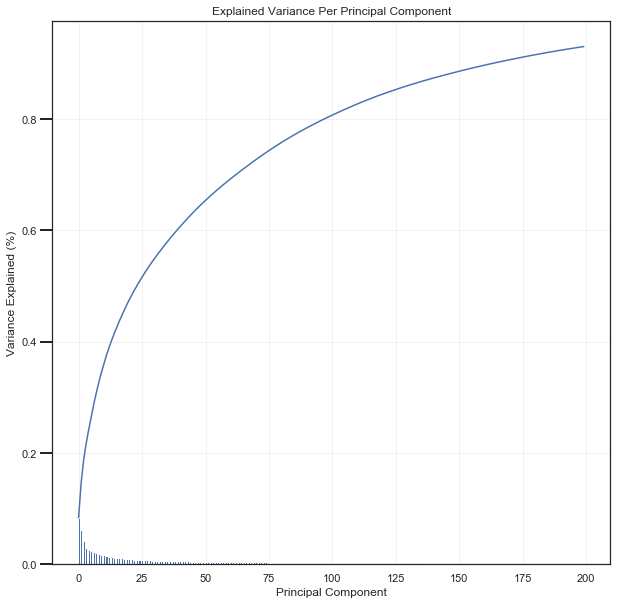

In [273]:
plot_variance(pca)

In [274]:
# we see from the above that roughly 150 of the components explain more than 85% of the variance
# also the variance explained does not increase at a high rate with the increase in the number of components beyond 150
# Hence let's now reduce the number of PCA components to 150 and get those components
pca_150, X_pca_150 = do_pca(azdias_transformed, 150)

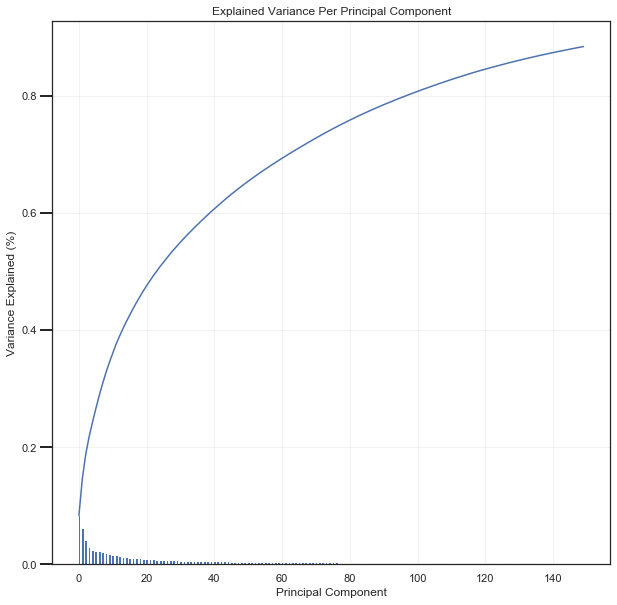

In [275]:
# let's look at the explained variance now to confirm
plot_variance(pca_150)

In [276]:
# now let's look at a few components and map it to the features that contribute the most to those components
pca_150.components_

array([[-0.02374455, -0.02783238,  0.14966991, ...,  0.11421508,
        -0.0662734 ,  0.03225937],
       [-0.04340281, -0.01975375,  0.07824967, ...,  0.01929022,
        -0.02265582,  0.01280626],
       [-0.01784027,  0.07144743,  0.01426032, ...,  0.00945201,
         0.03619833, -0.25057164],
       ...,
       [ 0.02638865, -0.00776754,  0.10508432, ...,  0.0922433 ,
         0.00115125,  0.02835816],
       [-0.00503412, -0.01384916,  0.00191547, ..., -0.00514348,
        -0.00399031, -0.0256659 ],
       [-0.01181988,  0.03764138,  0.00305579, ..., -0.0729949 ,
        -0.00126108, -0.02795871]])

In [277]:
component_names = ['comp-{}'.format(i) for i in range(1, len(pca_150.components_)+1)]
df_components = pd.DataFrame(pca_150.components_, columns=azdias_transformed.columns, index=component_names)
df_components.head()

,EINGEFUEGT_AM,WOHNDAUER_2008,ANZ_STATISTISCHE_HAUSHALTE,ANZ_PERSONEN,D19_BANKEN_ONLINE_QUOTE_12,ANZ_HAUSHALTE_AKTIV,NATIONALITAET_KZ,MIN_GEBAEUDEJAHR,PLZ8_BAUMAX_FAMILY,KBA05_ANTG4,D19_RATGEBER,KBA05_ANTG3,KBA13_KMH_251,KBA13_KMH_110,KBA13_ANZAHL_PKW,KBA13_KW_30,RURAL_NEIGHBORHOOD,GREEN_AVANTGARDE,VERS_TYP,PLZ8_BAUMAX_BUSINESS,KBA05_SEG6,ANREDE_KZ,MAINSTREAM,OST_WEST_KZ,SOHO_KZ,DSL_FLAG,UNGLEICHENN_FLAG,KONSUMZELLE,HH_DELTA_FLAG,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,GEBAEUDETYP_RASTER_1,GEBAEUDETYP_RASTER_2,GEBAEUDETYP_RASTER_3,GEBAEUDETYP_RASTER_4,GEBAEUDETYP_RASTER_5,HEALTH_TYP_1,HEALTH_TYP_2,HEALTH_TYP_3,KBA05_MAXHERST_1,KBA05_MAXHERST_2,KBA05_MAXHERST_3,KBA05_MAXHERST_4,KBA05_MAXHERST_5,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,KBA05_HERSTTEMP_1,KBA05_HERSTTEMP_2,KBA05_HERSTTEMP_3,KBA05_HERSTTEMP_4,KBA05_HERSTTEMP_5,KBA13_BAUMAX_1,KBA13_BAUMAX_2,KBA13_BAUMAX_3,KBA13_BAUMAX_4,KBA13_BAUMAX_5,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,GFK_URLAUBERTYP_12,D19_KONSUMTYP_1,D19_KONSUMTYP_2,D19_KONSUMTYP_3,D19_KONSUMTYP_4,D19_KONSUMTYP_5,D19_KONSUMTYP_6,D19_KONSUMTYP_9,CJT_TYP_5_1,CJT_TYP_5_2,CJT_TYP_5_3,CJT_TYP_5_4,CJT_TYP_5_5,CJT_TYP_4_1,CJT_TYP_4_2,CJT_TYP_4_3,CJT_TYP_4_4,CJT_TYP_4_5,D19_VERSI_OFFLINE_DATUM_1,D19_VERSI_OFFLINE_DATUM_2,D19_VERSI_OFFLINE_DATUM_3,D19_VERSI_OFFLINE_DATUM_4,D19_VERSI_OFFLINE_DATUM_5,D19_VERSI_OFFLINE_DATUM_6,D19_VERSI_OFFLINE_DATUM_7,D19_VERSI_OFFLINE_DATUM_8,D19_VERSI_OFFLINE_DATUM_9,D19_VERSI_OFFLINE_DATUM_10,KOMBIALTER_1,KOMBIALTER_2,KOMBIALTER_3,KOMBIALTER_4,KOMBIALTER_9,D19_VERSI_DATUM_1,D19_VERSI_DATUM_2,D19_VERSI_DATUM_3,D19_VERSI_DATUM_4,D19_VERSI_DATUM_5,D19_VERSI_DATUM_6,D19_VERSI_DATUM_7,D19_VERSI_DATUM_8,D19_VERSI_DATUM_9,D19_VERSI_DATUM_10,CJT_TYP_3_1,CJT_TYP_3_2,CJT_TYP_3_3,CJT_TYP_3_4,CJT_TYP_3_5,UMFELD_ALT_1,UMFELD_ALT_2,UMFELD_ALT_3,UMFELD_ALT_4,UMFELD_ALT_5,VHA_0,VHA_1,VHA_2,VHA_3,VHA_4,VHA_5,MOBI_RASTER_1,MOBI_RASTER_2,MOBI_RASTER_3,MOBI_RASTER_4,MOBI_RASTER_5,MOBI_RASTER_6,UMFELD_JUNG_1,UMFELD_JUNG_2,UMFELD_JUNG_3,UMFELD_JUNG_4,UMFELD_JUNG_5,KBA13_KMH_210_1,KBA13_KMH_210_2,KBA13_KMH_210_3,KBA13_KMH_210_4,KBA13_KMH_210_5,KBA13_CCM_1401_2500_1,KBA13_CCM_1401_2500_2,KBA13_CCM_1401_2500_3,KBA13_CCM_1401_2500_4,KBA13_CCM_1401_2500_5,D19_SOZIALES_0,D19_SOZIALES_1,D19_SOZIALES_2,D19_SOZIALES_3,D19_SOZIALES_4,D19_SOZIALES_5,D19_VERSI_ONLINE_DATUM_1,D19_VERSI_ONLINE_DATUM_2,D19_VERSI_ONLINE_DATUM_3,D19_VERSI_ONLINE_DATUM_4,D19_VERSI_ONLINE_DATUM_5,D19_VERSI_ONLINE_DATUM_6,D19_VERSI_ONLINE_DATUM_7,D19_VERSI_ONLINE_DATUM_8,D19_VERSI_ONLINE_DATUM_9,D19_VERSI_ONLINE_DATUM_10,AKT_DAT_KL_1,AKT_DAT_KL_2,AKT_DAT_KL_3,AKT_DAT_KL_4,AKT_DAT_KL_5,AKT_DAT_KL_6,AKT_DAT_KL_7,AKT_DAT_KL_8,AKT_DAT_KL_9,VHN_0,VHN_1,VHN_2,VHN_3,VHN_4,GEMEINDETYP_11,GEMEINDETYP_12,GEMEINDETYP_21,GEMEINDETYP_22,GEMEINDETYP_30,GEMEINDETYP_40,GEMEINDETYP_50,RT_KEIN_ANREIZ_1,RT_KEIN_ANREIZ_2,RT_KEIN_ANREIZ_3,RT_KEIN_ANREIZ_4,RT_KEIN_ANREIZ_5,RT_SCHNAEPPCHEN_1,RT_SCHNAEPPCHEN_2,RT_SCHNAEPPCHEN_3,RT_SCHNAEPPCHEN_4,RT_SCHNAEPPCHEN_5,CJT_TYP_1_1,CJT_TYP_1_2,CJT_TYP_1_3,CJT_TYP_1_4,CJT_TYP_1_5,CJT_TYP_2_1,CJT_TYP_2_2,CJT_TYP_2_3,CJT_TYP_2_4,CJT_TYP_2_5,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,CJT_TYP_6_5,RT_UEBERGROESSE_0,RT_UEBERGROESSE_1,RT_UEBERGROESSE_2,RT_UEBERGROESSE_3,RT_UEBERGROESSE_4,RT_UEBERGROESSE_5,CJT_KATALOGNUTZER_1,CJT_KATALOGNUTZER_2,CJT_KATALOGNUTZER_3,CJT_KATALOGNUTZER_4,CJT_KATALOGNUTZER_5,STRUKTURTYP_1,STRUKTURTYP_2,STRUKTURTYP_3,FIRMENDICHTE_1,FIRMENDICHTE_2,FIRMENDICHTE_3,FIRMENDICHTE_4,FIRMENDICHTE_5,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,D19_BUCH_CD,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP_MAX,D

In [278]:
def show_top_n_fetaures(component_n, n_features):
    '''
    component_n: prinicipal component number
    n_features: number of top positive and top negatively contributing features
    '''
    comp_name = 'comp-{}'.format(component_n)
    top_5 = df_components.loc[comp_name].sort_values(ascending=False)[:n_features]
    neg_5 = df_components.loc[comp_name].sort_values(ascending=True)[:n_features]
    
    print('Top 5 features positively corelated to compoenent {} are:'.format(component_n))
    print(top_5)
    
    print('Top 5 features negatively corelated to compoenent {} are:'.format(component_n))
    print(neg_5)

In [279]:
show_top_n_fetaures(1, 5)

Top 5 features positively corelated to compoenent 1 are:
CAMEO_DEUG_2015               0.155060
HH_EINKOMMEN_SCORE            0.152517
ANZ_HAUSHALTE_AKTIV           0.151011
KBA13_ANTG3                   0.149684
ANZ_STATISTISCHE_HAUSHALTE    0.149670
Name: comp-1, dtype: float64
Top 5 features negatively corelated to compoenent 1 are:
MOBI_REGIO       -0.161222
KBA13_ANTG1      -0.153771
KBA05_ANTG1      -0.152390
LP_STATUS_GROB   -0.146832
KBA05_GBZ        -0.144822
Name: comp-1, dtype: float64


In [280]:
show_top_n_fetaures(2, 5)

Top 5 features positively corelated to compoenent 2 are:
KBA13_HERST_BMW_BENZ           0.185316
KBA13_SEG_OBEREMITTELKLASSE    0.161621
KBA13_BMW                      0.157087
KBA13_MERCEDES                 0.155614
KBA13_SITZE_4                  0.147232
Name: comp-2, dtype: float64
Top 5 features negatively corelated to compoenent 2 are:
KBA13_SITZE_5          -0.145409
KBA13_ALTERHALTER_60   -0.136636
KBA13_KMH_140_210      -0.134563
KBA13_HALTER_20        -0.132945
KBA13_SEG_KLEINWAGEN   -0.129399
Name: comp-2, dtype: float64


In [281]:
show_top_n_fetaures(3, 5)

Top 5 features positively corelated to compoenent 3 are:
ALTERSKATEGORIE_GROB    0.227058
FINANZ_VORSORGER        0.223007
SEMIO_ERL               0.177009
SEMIO_LUST              0.169748
RETOURTYP_BK_S          0.153082
Name: comp-3, dtype: float64
Top 5 features negatively corelated to compoenent 3 are:
DECADE                  -0.250572
FINANZ_SPARER           -0.243799
SEMIO_PFLICHT           -0.224748
SEMIO_REL               -0.219816
FINANZ_UNAUFFAELLIGER   -0.215558
Name: comp-3, dtype: float64


In [282]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [283]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n):
    '''
    PARAMS:
        data - dataframe that contains the data to cluster
        n - number of clusters required
    RETURN
        Returns the KMeans clustering score
    '''
    kmeans = KMeans(n_clusters=n, random_state=1, n_jobs=6)
    model = kmeans.fit(data)
    return np.abs(model.score(data))

In [284]:
# try out KMeans with diff. number of clusters
# let's first try till 14 number of clusters to see if we can get an elbow that gives us an optimum
scores = []

for i in range(2,8,2):
    score = round(apply_kmeans(X_pca_150, i),2)
    print('center : {}     score : {}'.format(i, score))
    scores.append(score)

center : 2     score : 156686042.35
center : 4     score : 147905944.51
center : 6     score : 143343986.73


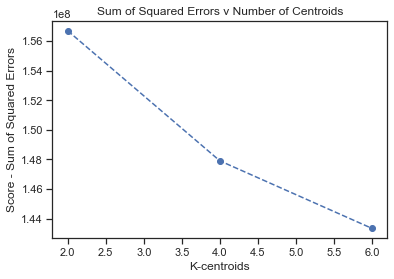

In [285]:
# Let's plot the scores against the number of clusters
plt.plot(range(2,8,2), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K-centroids');
plt.ylabel('Score - Sum of Squared Errors');
plt.title('Sum of Squared Errors v Number of Centroids');

In [286]:
# From the above chart, a slight elbow shape can be seen at 6, hence let's go with 6 clusters

kmeans_6 = KMeans(n_clusters=6, random_state=1)

# Then fit the model to your data using the fit method
model_general = kmeans_6.fit(X_pca_150)

# Finally predict the labels or clusters on the same data using the predict method 
predict_general_clusters = model_general.predict(X_pca_150)

In [287]:
predict_general_clusters

array([0, 3, 1, ..., 4, 0, 2], dtype=int32)

In [288]:
# look at the cluster number that the first few 

In [289]:
pd.Series(predict_general_clusters).value_counts().sort_values()

5     92788
3     98077
0    116231
2    122298
4    136690
1    171204
dtype: int64

In [290]:
# Now let's perform clustering on the customer data

In [291]:
# performm PCA on the customer data
customers_pca = pca_150.transform(cust_transformed)

In [292]:
customers_clusters = kmeans_6.predict(customers_pca)

In [293]:
customers_clusters

array([1, 2, 1, ..., 2, 2, 4], dtype=int32)

In [294]:
pd.Series(customers_clusters).value_counts().sort_values()

5     8631
0    12375
4    18333
3    24745
2    28279
1    41883
dtype: int64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [295]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [296]:
print(mailout_train.shape)
print((mailout_train.RESPONSE.sum())*100/len(mailout_train))

(42962, 367)
1.2383036171500397


In [297]:
mailout_train_cleaned = clean_data(mailout_train, False) # we do not want precious positive responses dropped

[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[0]
[0]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]

In [298]:
mailout_train_cleaned.shape

(42962, 283)

# Observations on data

1. The percentage of folks who actually become a customer is very less... hence we need a way to score with a higher recall

In [299]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

0


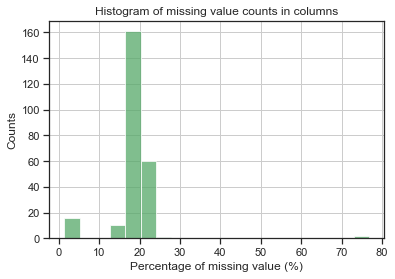

,nulls,pct
FAMILY_TYPE,32946,76.69
HOUSEHOLD,32946,76.69
W_KEIT_KIND_HH,10417,24.25
REGIOTYP,9930,23.11
KKK,9930,23.11
HH_DELTA_FLAG,9678,22.53
KBA05_MAXVORB,9031,21.02
KBA05_DIESEL,9031,21.02
KBA05_HERST4,9031,21.02
KBA05_HERST3,9031,21.02


In [300]:
print(mailout_train_cleaned.RESPONSE.isnull().sum())
mailout_nulls = get_null_counts(mailout_train_cleaned)
plot_hist_missing_col(mailout_nulls)
mailout_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False)
# mailout_nulls

In [327]:
df_responses = mailout_train_cleaned.RESPONSE

mailout_train_transformed = ct.fit_transform(mailout_train_cleaned.drop(columns='RESPONSE'))

In [328]:
mailout_train_transformed = convert_to_dataframe(mailout_train_transformed)

In [303]:
import time
def show_confusion_matrix(classifier, X_test, y_test):
    class_names=['NO', 'YES']
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

def fit_classifier(clf, param_grid, X_train, Y_train, X_test, Y_test):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=4, n_jobs=4)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X_train, Y_train)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    show_confusion_matrix(grid.best_estimator_, X_test, Y_test)
    
    print('--------------------------------')
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [304]:
# Let's split the data into train and test data for our model buidling purposes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mailout_train_transformed, df_responses, test_size=0.2, random_state=40)

Training GradientBoostingClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  4.0min finished


GradientBoostingClassifier
Time taken : 354.29 secs
Best score : 0.7629
****************************************
Confusion matrix, without normalization
[[8487    4]
 [ 102    0]]
Normalized confusion matrix
[[9.99528913e-01 4.71087033e-04]
 [1.00000000e+00 0.00000000e+00]]


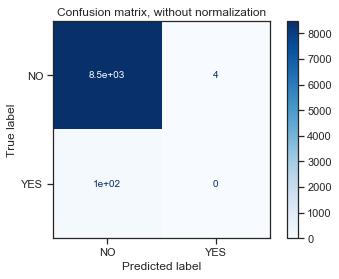

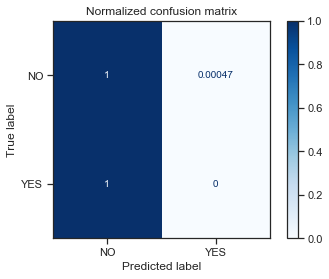

--------------------------------


In [305]:
models = [GradientBoostingClassifier()]
for model in models:
    fit_classifier(model, {}, X_train, y_train, X_test, y_test)

Training GradientBoostingClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.8min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.9min finished


GradientBoostingClassifier
Time taken : 502.6 secs
Best score : 0.7663
****************************************
Confusion matrix, without normalization
[[8491    0]
 [ 102    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


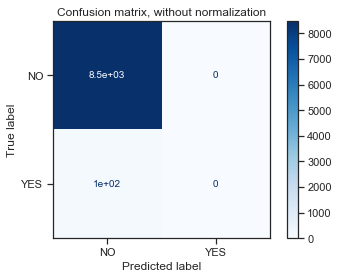

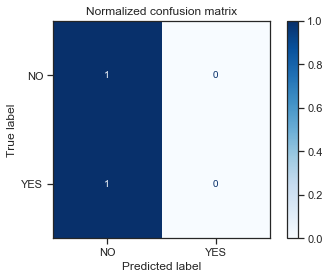

--------------------------------


In [314]:
_, best_estimator, _ = fit_classifier(GradientBoostingClassifier(), {}, mailout_train_transformed, df_responses, X_test, y_test)

In [315]:
best_estimator

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [316]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.shape

(42833, 366)

In [317]:
mailout_test_cleaned = clean_data(mailout_test, False)
mailout_test_cleaned.shape

[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[0]
[0]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[10]
[0]
[10]
[10]
[0]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[0]
[0]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]

(42833, 282)

In [318]:
mailout_test_cleaned = mailout_test_cleaned[mailout_train_cleaned.drop(["RESPONSE"], axis=1).columns]
mailout_test_cleaned.shape

(42833, 282)

In [329]:
mailout_test_transformed = ct.transform(mailout_test_cleaned)
mailout_test_transformed = convert_to_dataframe(mailout_test_transformed)

In [330]:
mailout_test_transformed.shape

(42833, 467)

In [331]:
# let's check if all the columns of customers and azdias are the same
print(set(mailout_test_transformed.columns).difference(set(mailout_train_transformed.columns)))
print('------------------------')
print(set(mailout_train_transformed.columns).difference(set(mailout_test_transformed.columns)))

set()
------------------------
set()


In [332]:
mailout_test.LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [333]:
probs = best_estimator.predict_proba(mailout_test_transformed)

In [334]:
probs.shape

(42833, 2)

In [335]:
probs[:10,1]

array([0.03921775, 0.02950981, 0.00262762, 0.002992  , 0.00211678,
       0.00169178, 0.00106006, 0.02128679, 0.0225526 , 0.00390717])

In [336]:
kaggle_dict = {'LNR': mailout_test.LNR, 'RESPONSE': probs[:,1]}
df_kaggle = pd.DataFrame(data=kaggle_dict)
df_kaggle.head()

,LNR,RESPONSE
0,1754,0.039218
1,1770,0.029510
2,1465,0.002628
3,1470,0.002992
4,1478,0.002117


In [337]:
df_kaggle.to_csv('arvato_test_response2.csv', index=False)